导入库

In [1]:
import os
import numpy as np
import json

import utils
from dataset import EEGAudioDataset
from torch_dct import dct

公共变量

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
words_path = r'./feat/words'
pts = ['sub-%02d'%i for i in range(1,11)]
pt = 'sub-08'
test_word = 0
config_path = r'./config'
model_name = 'vqvae_cls_n512_d1024'
model_name = 'trans_pred4_m80'

读取数据

In [3]:
folder_path = os.path.join(words_path,f'{pt}')
filename = os.listdir(folder_path)[test_word]
word_info = np.load(os.path.join(folder_path,filename),allow_pickle=True)
word=word_info.item()['label']
eeg=word_info.item()['eeg']
audio=word_info.item()['audio']

print(word,eeg.shape,audio.shape)

maantje (901, 54) (14080,)


数据预处理

In [4]:
with open(os.path.join(config_path,f'{model_name}.json'),'r') as f:
    cfg = json.load(f)
    model_cfg = cfg['model_config']
    data_cfg = cfg['data_config']

# load config 
seg_size = model_cfg['seg_size']
pred_size = model_cfg['pred_size']
batch_size = model_cfg['batch_size']
# batch_size = model_cfg['batch_size']
# end_epoch = model_cfg['epochs'] if argu.epoch is None else argu.epoch
lr = model_cfg['lr']
b1 = model_cfg['b1']
b2 = model_cfg['b2']
# clip_grad = model_cfg['clip_grad']
# hidden_dim = model_cfg['hidden_dim']
# mel_d_model = model_cfg['mel_d_model']
# eeg_d_model = model_cfg['eeg_d_model']
d_model = model_cfg['d_model']
num_embeddings = model_cfg['num_embeddings']
embedding_dim = model_cfg['embedding_dim']
nhead = model_cfg['nhead']
n_layer = model_cfg['n_layer']
# n_embedding = model_cfg['n_embedding']

data_path = data_cfg['data_path']
win_len = data_cfg['win_len']
frame_shift = data_cfg['frame_shift']
eeg_sr = data_cfg['eeg_sr']
audio_sr = data_cfg['audio_sr']
n_mels = data_cfg['n_mels']
pad_mode = data_cfg['pad_mode']

提取高频eeg信号和音频信号的梅尔频谱

In [5]:
eeg = EEGAudioDataset.extractHG(eeg,eeg_sr,windowLength=win_len,frameshift=frame_shift)
melspec = EEGAudioDataset.extractMelSpecs(audio,audio_sr,windowLength=win_len,frameshift=frame_shift,n_mels=n_mels)
# print(eeg.shape,melspec.shape)
if melspec.shape[0]!=eeg.shape[0]:
    minlen = min(melspec.shape[0],eeg.shape[0])
    melspec = melspec[:minlen,:]
    eeg = eeg[:minlen,:]
print(eeg.shape,melspec.shape)

(110, 54) (110, 80)


预处理

In [6]:
eeg_mean = np.mean(eeg)
eeg_std = np.std(eeg)
eeg = (eeg-eeg_mean)/eeg_std
eeg_list = []
mel_list = []
hop_size = 1
pad_width = ((int(np.floor((seg_size-hop_size)/2.0)),int(np.ceil((seg_size-hop_size)/2.0))),(0,0))
pad_eeg = np.pad(eeg,pad_width,mode=pad_mode)
pad_mel = np.pad(melspec,pad_width,mode=pad_mode)
num_win = int(len(eeg)/float(hop_size))
for i in range(num_win):
    start = i*hop_size
    end = start + seg_size
    eeg_list.append(pad_eeg[start:end,:])
    mel_list.append(pad_mel[start:end,:])

eeg_data = np.stack(eeg_list,axis=0)
mel_data = np.stack(mel_list,axis=0)
print(eeg_data.shape,mel_data.shape)

(110, 16, 54) (110, 16, 80)


加载模型

In [7]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

from itertools import chain
from model.VQVAE import  MelEncoder,EEGEncoder,VectorQuantizer,MelLinearDecoder,LinearClassifier

In [8]:
from model.models import Model

In [215]:
input_dim = eeg_data.shape[-1]
output_dim = mel_data.shape[-1]

tensor_type = torch.cuda.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

eeg_encoder = EEGEncoder(input_dim=input_dim,d_model=d_model,n_layer=n_layer).to(device)
mel_encoder = MelEncoder(input_dim=output_dim,d_model=d_model).to(device)
vector_quantizer = VectorQuantizer(num_embeddings=n_embedding,embedding_dim=embedding_dim).to(device)
mel_decoder = MelLinearDecoder(output_dim=output_dim,d_model=d_model,seg_size=seg_size).to(device)
classifier = LinearClassifier(num_embedding=n_embedding,embedding_dim=embedding_dim).to(device)

# eeg_optimizer = torch.optim.Adam(chain(eeg_encoder.parameters(),classifier.parameters()),lr=lr,betas=(b1,b2))
# scheduler = MultiStepLR(main_optimizer,milestones=[10,20,30],gamma=0.5)

l1loss = nn.SmoothL1Loss().double().to(device)
loss_fn = lambda x,y:(l1loss(x.double(), y.double())+l1loss(torch.exp(x.double()).double(),torch.exp(y.double()).double())+l1loss(dct(x.double(),norm='ortho').double(),dct(y.double(),norm='ortho').double()))

checkpoint = utils.scan_checkpoint(f'./res/{pt}/{model_name}',f'{model_name}')
state_dict = utils.load_checkpoint(checkpoint)
eeg_encoder.load_state_dict(state_dict['eeg_encoder'])
mel_encoder.load_state_dict(state_dict['mel_encoder'])
vector_quantizer.load_state_dict(state_dict['vector_quantizer'])
mel_decoder.load_state_dict(state_dict['mel_decoder'])
classifier.load_state_dict(state_dict['classifier'])

eeg_encoder.eval()
mel_encoder.eval()
vector_quantizer.eval()
mel_decoder.eval()
classifier.eval()


In [9]:
input_dim = eeg_data.shape[-1]
output_dim = mel_data.shape[-1]

tensor_type = torch.cuda.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Model(
    input_dim=input_dim,
    output_dim=output_dim,
    seg_size=seg_size,
    pred_size=pred_size,
    d_model=d_model,
    num_embeddings=num_embeddings,
    embedding_dim = embedding_dim,
    nhead=nhead,
    n_layer=n_layer
).to(device)

l1loss = nn.SmoothL1Loss().double().to(device)
loss_fn = lambda x,y:(l1loss(x.double(), y.double())+l1loss(torch.exp(x.double()).double(),torch.exp(y.double()).double())+l1loss(dct(x.double(),norm='ortho').double(),dct(y.double(),norm='ortho').double()))

checkpoint = utils.scan_checkpoint(f'./res/{pt}/{model_name}',f'{model_name}')
state_dict = utils.load_checkpoint(checkpoint)
model.load_state_dict(state_dict=state_dict['model_state_dict'])
# optimizer.load_state_dict(state_dict=state_dict['optimizer_state_dict'])
start_epoch = state_dict['epoch']
model.eval()

Loading './res/sub-08/trans_pred4_m80/trans_pred4_m80_001000.pt'
Complete.


Model(
  (l1): Linear(in_features=54, out_features=256, bias=True)
  (transformer): Transformer(
    (RoPEMultiHeadAttention): RotaryPEMultiHeadAttention(
      (query): PrepareForMultiHeadAttention(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (key): PrepareForMultiHeadAttention(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (value): PrepareForMultiHeadAttention(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (softmax): Softmax(dim=2)
      (output): Linear(in_features=256, out_features=256, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (query_rotary_pe): RotaryPositionalEmbeddings()
      (key_rotary_pe): RotaryPositionalEmbeddings()
    )
    (ff): ConvFeedForward(
      (layer1): Conv1d(256, 1024, kernel_size=(9,), stride=(1,), padding=(4,))
      (layer2): Conv1d(1024, 256, kernel_size=(1,), stride=(1,))
      (dropout): Dropout(p=0.1, inplace=Fals

In [10]:
eeg_data =torch.from_numpy(eeg_data).to(device).type(tensor_type)
mel_data = torch.from_numpy(mel_data).to(device).type(tensor_type)

In [11]:
eeg_out = model(eeg_data)

In [218]:
encoded_eeg = eeg_encoder(eeg_data)
encoded_mel = mel_encoder(mel_data)
eeg_vq = classifier.cls(encoded_eeg)
_,mel_vq = vector_quantizer(encoded_mel)
eeg_out = mel_decoder(eeg_vq)
mel_out = mel_decoder(mel_vq)


In [12]:
eeg_out = torch.clamp(eeg_out,np.log(1e-5),np.log(1e4))
eeg_out = eeg_out.detach().cpu().numpy()

In [220]:
mel_out = mel_out.detach().cpu().numpy()

In [16]:
mel_data = mel_data.detach().cpu().numpy()

In [13]:
import librosa.display
import matplotlib.pyplot as plt
def nolabel():
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])

    plt.xlabel('')
    plt.ylabel('')

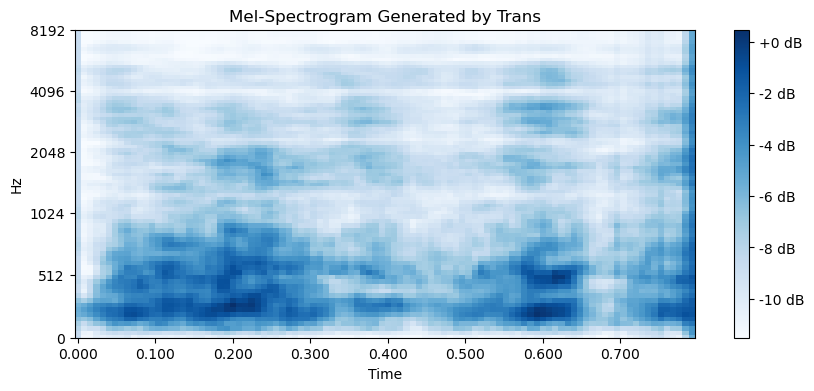

In [20]:
# utils.plot_spectrogram(eeg_out[:-4],audio_sr,int(audio_sr*frame_shift),int(audio_sr*win_len))
plt.figure(figsize=(10,4))
librosa.display.specshow(utils.getFlatMel(eeg_out[:-10]).T,sr=audio_sr,hop_length=int(audio_sr*frame_shift),n_fft=int(audio_sr*win_len),x_axis='time',y_axis='mel',cmap='Blues')
plt.ylim(0,8192)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram Generated by Trans')
# nolabel()
np.save(os.path.join('test_mel_files',f'{pt}_{test_word}_{word}_eeg_trans.npy'),utils.getFlatMel(eeg_out).T)

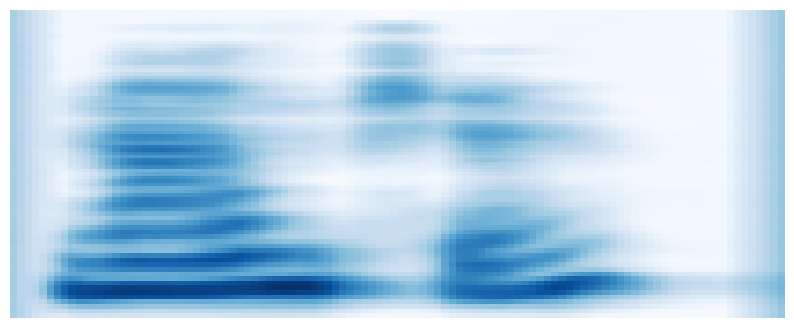

In [250]:
# utils.plot_spectrogram(mel_out[:-4],audio_sr,int(audio_sr*frame_shift),int(audio_sr*win_len))
plt.figure(figsize=(10,4))
librosa.display.specshow(utils.getFlatMel(mel_out[:-4]).T,sr=audio_sr,hop_length=int(audio_sr*frame_shift),n_fft=int(audio_sr*win_len),x_axis='time',y_axis='mel',cmap='Blues')
# plt.ylim(0,8192)
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel-Spectrogram Generated by Pretrained VQVAE')
nolabel()

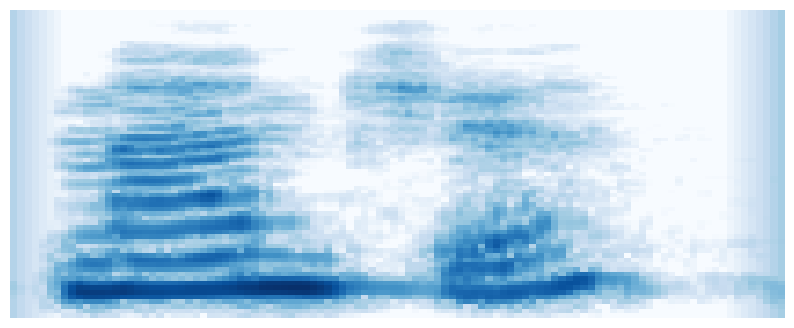

In [17]:
# utils.plot_spectrogram(mel_data[:-4],audio_sr,int(audio_sr*frame_shift),int(audio_sr*win_len))
plt.figure(figsize=(10,4))
librosa.display.specshow(utils.getFlatMel(mel_data[:-4]).T,sr=audio_sr,hop_length=int(audio_sr*frame_shift),n_fft=int(audio_sr*win_len),x_axis='time',y_axis='mel',cmap='Blues')
# plt.ylim(0,8192)
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel-Spectrogram of Original Audio')
nolabel()

In [225]:

np.save(os.path.join('test_mel_files',f'{pt}_{test_word}_{word}_mel.npy'),utils.getFlatMel(mel_out).T)
np.save(os.path.join('test_mel_files',f'{pt}_{test_word}_{word}_origin.npy'),utils.getFlatMel(mel_data).T)


(14080,)


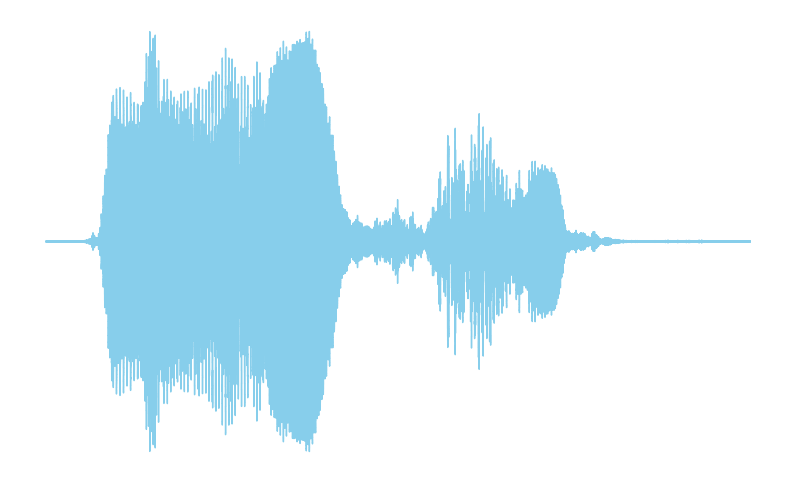

In [226]:
import matplotlib.pyplot as plt
import librosa.display

print(audio.shape)
plt.figure(figsize=(10, 6))
librosa.display.waveshow(np.float32(audio), sr=audio_sr,color='skyblue')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])

plt.xlabel('')
plt.ylabel('')


# plt.title('Waveform')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
plt.show()

In [2]:
import numpy as np
np.std([23.97,24.19,25.20,24.55,26.35,23.63,22.29,21.87,23.92,24.51,24.05])

1.173315567734275

In [3]:
np.std([36.23,36.77,29.00,31.72,42.95,26.86,29.81,32.55,32.55,25.63,32.41])

4.674571620449381

In [4]:
np.std([28.79,28.61,30.28,28.05,29.13,29.95,29.39,28.81,27.72,30.18,29.09])

0.7858227251561902